# Prerequisites
All computational and statistics packages have been tested in Anaconda environment (python 3.6)
1. Install Anaconda
https://www.anaconda.com/download/#linux
2. Install Spark and Java 8
https://medium.com/@GalarnykMichael/install-spark-on-ubuntu-pyspark-231c45677de0  

***Install "pyspark"***

In [1]:
"""try:
    print('Trying to import pyspark...')
    import pyspark
except ImportError:
    print('Pyspark import failed...')
    print('Installing pyspark in conda environment...')
    import sys
    !conda install --yes --prefix {sys.prefix} pyspark"""

"try:\n    print('Trying to import pyspark...')\n    import pyspark\nexcept ImportError:\n    print('Pyspark import failed...')\n    print('Installing pyspark in conda environment...')\n    import sys\n    !conda install --yes --prefix {sys.prefix} pyspark"

***Create Spark Context***
If you enqounter any error, try to reconfigure Spark on your machine (link in the first cell - .bashrc file configuration).

In [2]:
from pyspark import SparkConf, SparkContext
try:
    sc
except NameError:
    conf = SparkConf().setAppName('SDN')
    sc = SparkContext(conf=conf)
else:
    if sc != None:
        sc.stop()
    conf = SparkConf().setAppName('SDN')
    sc = SparkContext(conf=conf)

Create SQL context for spark computation.

In [3]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [4]:
from os import system
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta
import time
import scipy.stats as sts

from apscheduler.schedulers.background import BackgroundScheduler
from apscheduler.triggers.interval import IntervalTrigger
import matplotlib.dates as mdates
import json
import urllib
import logging, sys

In [5]:
try:
    print('Trying to import paramiko...')
    import paramiko
    print('Paramiko imported.')
except ImportError:
    print('Paramiko import failed...')
    print('Installing paramiko in conda environment...')
    import sys
    !conda install --yes --prefix {sys.prefix} paramiko

Trying to import paramiko...
Paramiko imported.


Paramiko installation

SCP installation

In [6]:
try:
    print('Trying to import scp...')
    import scp
    print('Scp imported.')
except ImportError:
    print('Scp import failed...')
    print('Installing scp in conda environment...')
    import sys
    !conda install --yes --prefix {sys.prefix} scp

Trying to import scp...
Scp imported.


Keras installation

In [7]:
try:
    print('Trying to import keras...')
    import keras
    print('Keras imported.')
except ImportError:
    print('Keras import failed...')
    print('Installing keras in conda environment...')
    import sys
    !conda install --yes --prefix {sys.prefix} keras

Trying to import keras...


Using TensorFlow backend.


Keras imported.


In [8]:
# keras
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense

In [9]:
def loginanddownload(hostname,uname,pwd,sfile,tfile):
    """
    Can copy files and directories from PNDa to remote system.
    Usage example:
        loginanddownload(red_pnda_ip, username, password, remote_folder, local_destination)
        loginanddownload('192.168.57.4', 'pnda', 'pnda', '/data', '/home/amadeusz/')
    
    I am using it only for download full copy of /data folder from pnda VM. There is a dependency of openssh-server
    installation on red_pnda VM.
    
    """
    try:
        print("Establishing ssh connection")
        ssh_client = paramiko.SSHClient()
        ssh_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        ssh_client.connect(hostname=hostname, username=uname, password=pwd)
    except paramiko.AuthenticationException:
        print("Authentication failed, please verify your credentials: %s")
    except paramiko.SSHException as sshException:
        print("Unable to establish SSH connection: %s" % sshException)
    except paramiko.BadHostKeyException as badHostKeyException:
        print("Unable to verify server's host key: %s" % badHostKeyException)
    except Exception as e:
        print(e.args)
    try:
        print("Getting SCP Client")
        scpclient = scp.SCPClient(ssh_client.get_transport())
        print("Hostname: %s", hostname)
        print("source file: %s", sfile)
        print("target file: %s", tfile)
        scpclient.get(sfile,tfile, recursive = True)
    except scp.SCPException as e:
        print("Operation error: %s", e) 

In [10]:
class Prediction:
    """
    Prediction class - class for preprocessing data from red_pnda.
    Not full variables are in use (this is a changed copy of Lecturer shared file)
    
    Prediction class takes exacly one argument - bytes (network traffic data)
    It is further processed and returned in other format.
    
    """
    def __init__(self, bytes):
        self.bytes = bytes
        self.omega = 2.0 * np.pi / len(bytes)
        self.export = pd.DataFrame()
        self.x = None
        self.data = None
        self.y = None
        self.train = None
        self.index = None
        self.train_mean = None
        self.train_std = None

    def prepare_data_for_prediction(self):
        """
        From RAW data compute time dependency (x) and bandwidth (y).
        """
        self.train = self.bytes
        self.train_mean = np.mean(self.train)
        self.train_std = np.std(self.train)
        self.train = (self.train - self.train_mean) / self.train_std
        self.index = np.asarray(range(len(self.train)), dtype=np.float64)
        self.x = np.asarray(range(len(self.train)), dtype=np.float64)
        self.y = self.train
        self.data = pd.DataFrame(np.column_stack([self.x, self.y]), columns=['x', 'y'])

    def proceed_prediction(self, percent):
        """
        Start data preprocessing.
        """
        self.prepare_data_for_prediction()

***Load the data***
Preprocessed data will be stored in wd.resampled

In [133]:
npzfile = np.load("/home/misliwin/Desktop/sdn/SDN_data_preprocessing_simple_NN_with_data/test_data_2.npz")
npzfile['arr_0']
X_test_complete = npzfile['arr_0']
Y_test_complete = npzfile['arr_1']
series = npzfile['arr_2']

# Simple Neural Network part (only one step ahead prediction)

In [134]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
 
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# load dataset

diff_values = difference(series, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

print(np.shape(supervised_values))
 
# split data into train and test-sets
train, test = supervised_values[0:-2000], supervised_values[-2000:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
range_size = 450



(10794, 2)


***Create NN model in Keras***

In [135]:
from keras.layers import Dropout
from keras.constraints import maxnorm
from keras.models import load_model

model = load_model('/home/misliwin/Desktop/sdn/SDN_data_preprocessing_simple_NN_with_data/SDN_model_30min.h5')
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                7216      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 450)               7650      
_________________________________________________________________
dropout_2 (Dropout)          (None, 450)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 450)               202950    
_________________________________________________________________
dropout_3 (Dropout)          (None, 450)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 450)               202950    
Total para

In [136]:
# Predict test dataset without confidence interval
predictions = model.predict(X_test_complete, batch_size=1000)


In [137]:
# create tensorflow function to apply dropout during prediction
import keras.backend as K
f = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])

In [155]:
# invert scaling, differencing
pred = list()
X_vector = X_test_complete[:, -2:-1]
Y_vector = Y_test_complete[:, -1]
preds = predictions[:, -1]
for i in range(len(X_test_complete)):
    X, y = X_vector[i], Y_vector[i]
    #print(X)
    # invert scaling
    yhat = invert_scale(scaler, X, preds[i])

    # invert differencing
    yhat = inverse_difference(series, yhat, len(X_test_complete)+1-i)
    # store forecast
    pred.append(yhat)
    expected = series[len(train) + i + 1]
    
def estimate_gaussian(X):
    mu = np.mean(X, axis=0)
    sigma2 = np.var(X, axis=0)
    return mu, sigma2        
pred_array = np.array(pred)
mu, sigma2 = estimate_gaussian(pred)

lower_bound = 0.2
upper_bound = 0.8

low = np.quantile(pred_array, lower_bound)
upp = np.quantile(pred_array, upper_bound)


diff = np.mean(series[-2000+2*range_size+1:-1]) - np.mean(pred[1:])
pred = pred + diff


-202.29839074591018


In [156]:
# performance 
rmse = np.sqrt(mean_squared_error(series[-2000+2*range_size+1:-1], pred[1:]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 24.865


In [157]:
def select_threshold(y_val, p_val):
    step_size = (np.max(p_val) - np.min(p_val)) / 1000

    best_epsilon = 0.0
    best_F1 = 0.0

    for epsilon in np.arange(min(p_val), max(p_val), step_size):
        predictions = p_val < epsilon
        tp = np.sum(predictions[np.nonzero(y_val == True)])
        fp = np.sum(predictions[np.nonzero(y_val == False)])
        fn = np.sum(y_val[np.nonzero(predictions == False)] == True)
        if tp != 0:
            prec = 1.0 * tp / (tp + fp)
            rec = 1.0 * tp / (tp + fn)
            F1 = 2.0 * prec * rec / (prec + rec)
            if F1 > best_F1:
                best_F1 = F1
                best_epsilon = epsilon

    return best_epsilon, best_F1

In [158]:
for i,item in enumerate(pred[1:]):
    real_data_item = series[-2000+2*range_size+1:-1][i]
    diff = np.absolute(item - real_data_item)/item
    if diff > 0.1 and real_data_item < low and real_data_item > upp:
        print("anomaly")
    #print(diff)

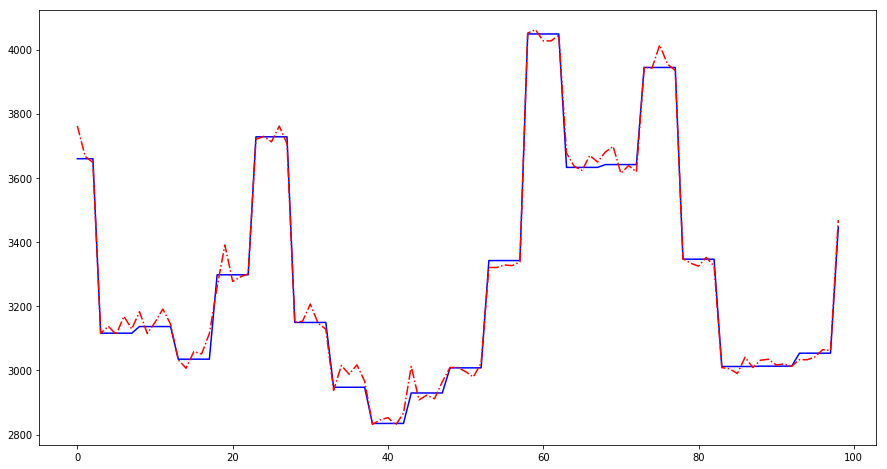

In [162]:
plot = 0

plt.figure(figsize=(15,8))
plt.plot(series[-2000+2*range_size+1:-1][1:100], 'b')
plt.plot(pred[1:][1:100], 'r-.') # predicted mean values
if plot:
    plt.figure(figsize=(15,8))
    plt.plot(series[-2000+2*range_size+1:-1], 'b')
    plt.plot(pred[1:], 'r-.') # predicted mean values
    #plt.plot(low*np.ones(len(pred[1:])), 'r') # predicted mean values
    #plt.plot(upp*np.ones(len(pred[1:])), 'r') # predicted mean values

#plt.plot(pred_array[1:]*1.1, 'r')
#plt.plot(pred_array[1:]*0.1, 'r')
#plt.fill_between(x = range(1999), y1 = p[1:]+u[1:], y2=p[1:]-u[1:]) # predicted uncertanity interval